# 概要
- このノートブックでは、ValueNetworkを学習させる。
- ネットワークの構造は以下のとおり。
    - 入力層：9チャネル
        - 黒石の位置(1)
        - 白石の位置(1)
        - 空白の位置(1)
        - 合法手の位置(1)
        - そこに打った場合、何個石を返せるか(1)
        - 隅の危険領域4マス×4隅をすべて1で埋める(1)
        - すべて1で埋める(1)
        - すべて0で埋める(1)
        - **手番情報：黒番ならすべて0で埋め、白番ならすべて1で埋める**(1)
    - 第1層：5x5のn_filters種類のフィルターとReLU関数
    - 第2-11層：3x3のn_filters種類のフィルターとReLU関数
    - 第12層：3x3のn_filters種類のフィルター
    - 第13層：1x1のn_filters種類のフィルター
    - 第14層：出力256個の全結合ネットワークとReLU関数
    - 第15層：出力1個の全結合ネットワークとtanh関数
- 学習データの作成方法は以下のとおり。（cf.AlphaGo解体新書p.171）
    - 1以上60以下の整数からランダムに数字を選択し、これをUとする。
    - SL-PolicyNetworkをU-1回使って、U-1手目まで局面を進める。
    - 次のU手目は合法手の中からランダムに選択し局面を進め、この局面をSとする。
    - 局面Sからは、RLポリシーネットワークを使って、終局まで手を進める。最終的な勝敗をzとする。
    - 組(S,z)を学習データとする。

In [1]:
!python -m pip install --no-index --find-links=/kaggle/input/reversi-datasets/ creversi

Looking in links: /kaggle/input/reversi-datasets/
Processing /kaggle/input/reversi-datasets/creversi-0.0.1-cp310-cp310-manylinux_2_24_x86_64.whl


In [2]:
from creversi import *

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from copy import copy
import os

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def board_to_array(board):
    """
    boardオブジェクトからndarrayに変換する関数(PolicyNetwork用)。
    第1チャンネルは黒石の位置、第2チャンネルに白石の位置、第3チャンネルに空白の位置、
    第4チャンネルに合法手の位置、第5チャンネルに返せる石の個数、第6チャンネルに隅=1、
    第7チャンネルに1埋め、第8チャンネルに0埋め。
    """
    b = np.zeros((8,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7],:,:]
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    return b

In [4]:
def board_to_array2(board):
    """
    boardオブジェクトからndarrayに変換する関数(ValueNetwork用)。
    第1チャネルは黒石の位置、第2チャネルに白石の位置、第3チャネルに空白の位置、
    第4チャネルに合法手の位置、第5チャネルに返せる石の個数、第6チャネルに隅=1、
    第7チャネルに1埋め、第8チャネルに0埋め、第9チャネルに手番情報(黒番=0埋め、白番=1埋め)
    """
    b = np.zeros((9,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7,8],:,:]
        b[8] = 1
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    return b

In [5]:
def board_to_array_aug(board, return_torch=False):
    boards = []
    board_array = board_to_array(board)
    boards.append(board_array)
    boards.append(np.flip(board_array,axis=2).copy())
    for k in range(1,4):
        board_array_rot = np.rot90(board_array, k=k, axes=(1,2)).copy()
        boards.append(board_array_rot)
        boards.append(np.flip(board_array_rot, axis=2).copy())
    if return_torch:
        return torch.from_numpy(np.array(boards))
    else:
        return np.array(boards)

In [6]:
def board_to_array_aug2(board, return_torch=False):
    boards = []
    board_array = board_to_array2(board)
    boards.append(board_array)
    boards.append(np.flip(board_array,axis=2).copy())
    for k in range(1,4):
        board_array_rot = np.rot90(board_array, k=k, axes=(1,2)).copy()
        boards.append(board_array_rot)
        boards.append(np.flip(board_array_rot, axis=2).copy())
    if return_torch:
        return torch.from_numpy(np.array(boards))
    else:
        return np.array(boards)

In [7]:
def test(moves_str, v_true, model, device):
    """
    Example:
     moves_str = "d3,e3,f2,e2,f5,c5,b6,e6,f6,c6,d6,c4,f3,f7,d7,e7,f4,b5,c3,g5,g6,b4,c7,d2,a6,a5,a3,a4,b3,d8,h6,h5,h4,g4,h3,g3,c2,f1,e1,d1,g2,g1,c1,b7,h1,b1,h2,a2,a8,a7,a1,b2,b8,c8,e8,g8,f8,g7,h8,h7"
     v_true = [0,0,-6,0,-8,0,-19,0,-11,-9,-16,-11,-20,-6,-10,0,-8,0,-18,-9,-10,-8,-7,0,0,0,0,0,-9,0,0,0,6,12,11,12,0,5,0,0,5,15,12,30,31,44,36,54,51,59,44,44,40,40,24,24,24,32,32,32]
    """
    moves = [move_from_str(move_str) for move_str in moves_str.split(',')]
    v_list = []
    board = Board()
    for move in moves:
        v = model(board_to_array_aug2(board,True).to(device)).detach().cpu().numpy().T[0]
        v_list.append(v*64)
        board.move(move)
    plt.figure(figsize=(4,1))
    plt.plot(v_list, c='red')
    plt.plot(np.array(v_list).mean(axis=1), c='orange')
    plt.plot(v_true, c='blue')
    plt.ylim(-64,64)
    plt.axhline(0, c='black', ls='--')
    plt.show()

In [8]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_filters = 10
        self.input_layer = nn.Sequential(
            nn.Conv2d(9,n_filters,kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.Conv2d(n_filters,n_filters,kernel_size=1,padding=1),
            nn.Flatten()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(n_filters*100, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self,x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out.tanh()

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 学習

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [11]:
states = None
results = None
for directory in sorted(os.listdir('/kaggle/input/reversi-datasets')):
    if directory.startswith('datav2-'):
        for file in sorted(os.listdir('/kaggle/input/reversi-datasets/'+directory)):
            if 'S-' in file:
                s = np.load('/kaggle/input/reversi-datasets/'+directory+'/'+file)
                if states is None:
                    states = s
                else:
                    states = np.concatenate([states, s], axis=0)
            elif 'z-' in file:
                z = np.load('/kaggle/input/reversi-datasets/'+directory+'/'+file)
                if results is None:
                    results = z
                else:
                    results = np.concatenate([results, z], axis=0)

states = np.array(states, dtype=np.float32)
results = np.array(results, dtype=np.float32).reshape(-1,1)
N = states.shape[0]
print(f"N : {N}")

N : 299869


In [12]:
test_size = 0.1
N_tr = int(N*(1-test_size))
N_va = N - N_tr

In [13]:
n_epoch = 10
n_batch = 256
lr = 0.001

criterion = nn.HuberLoss()
seed_everything(1234)
model = ValueNetwork().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr)

100%|██████████| 1054/1054 [01:00<00:00, 17.54it/s]


Epoch:1/10, train loss:0.04472, valid loss:0.04564


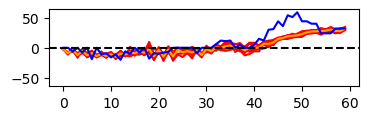

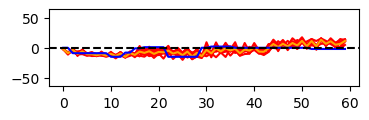

100%|██████████| 1054/1054 [00:59<00:00, 17.58it/s]


Epoch:2/10, train loss:0.03706, valid loss:0.04027


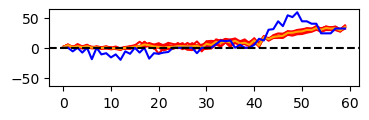

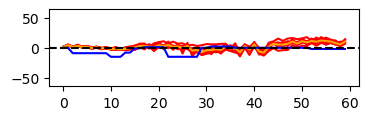

100%|██████████| 1054/1054 [01:00<00:00, 17.37it/s]


Epoch:3/10, train loss:0.03600, valid loss:0.03941


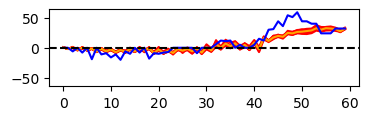

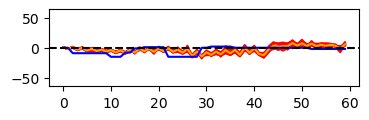

100%|██████████| 1054/1054 [01:01<00:00, 17.13it/s]


Epoch:4/10, train loss:0.03560, valid loss:0.03891


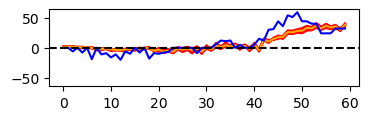

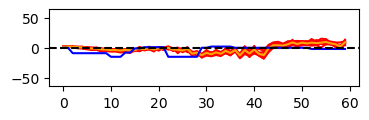

100%|██████████| 1054/1054 [01:00<00:00, 17.50it/s]


Epoch:5/10, train loss:0.03538, valid loss:0.03967


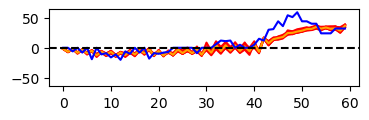

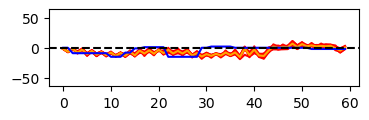

100%|██████████| 1054/1054 [01:00<00:00, 17.48it/s]


Epoch:6/10, train loss:0.03509, valid loss:0.03976


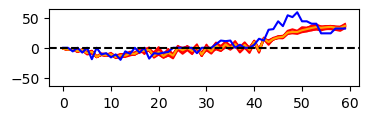

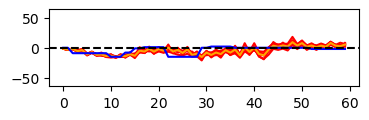

100%|██████████| 1054/1054 [01:00<00:00, 17.32it/s]


Epoch:7/10, train loss:0.03495, valid loss:0.03703


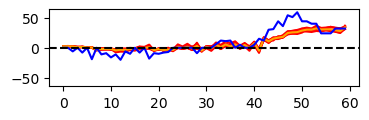

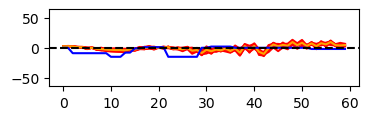

100%|██████████| 1054/1054 [01:01<00:00, 17.17it/s]


Epoch:8/10, train loss:0.03484, valid loss:0.03983


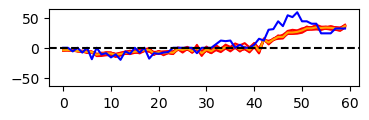

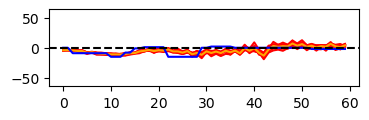

100%|██████████| 1054/1054 [01:00<00:00, 17.29it/s]


Epoch:9/10, train loss:0.03466, valid loss:0.03829


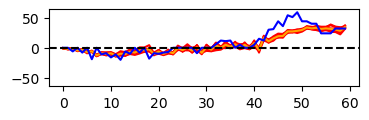

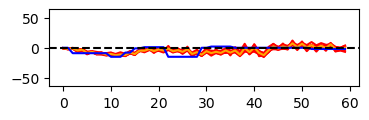

100%|██████████| 1054/1054 [01:00<00:00, 17.54it/s]


Epoch:10/10, train loss:0.03455, valid loss:0.03954


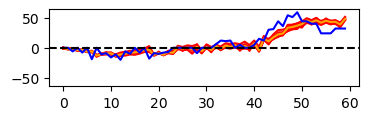

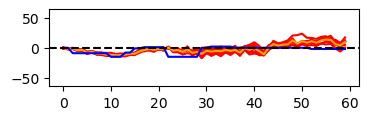

In [14]:
# 学習
train_loss_list = []
valid_loss_list = []
for epoch in range(n_epoch):
    train_loss = 0.
    np.random.seed(epoch)
    random_idx = np.random.permutation(N_tr)
    for i in tqdm(range(N_tr//n_batch)):
        X_batch = torch.from_numpy(states[random_idx[n_batch*i:n_batch*(i+1)]]).to(device)
        y_batch = torch.from_numpy(results[random_idx[n_batch*i:n_batch*(i+1)]]).to(device)

        model.train()
        optim.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optim.step()
        train_loss += loss.item()
    train_loss /= N_tr//n_batch

    # 評価
    model.eval()
    idx = np.array(range(N_tr,N))
    for i in range(N_va//n_batch):
        X_batch = torch.from_numpy(states[idx[n_batch*i:n_batch*(i+1)]]).to(device)
        y_batch = torch.from_numpy(results[idx[n_batch*i:n_batch*(i+1)]]).to(device)
    output = model(X_batch)
    valid_loss = criterion(output, y_batch).item()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print(f'Epoch:{epoch+1}/{n_epoch}, train loss:{train_loss:.5f}, valid loss:{valid_loss:.5f}')
    torch.save(model.cpu(), f'ValueNetwork-v2-checkpoint-{epoch+1}.pth')
    model.to(device)
    
    moves_str = "d3,e3,f2,e2,f5,c5,b6,e6,f6,c6,d6,c4,f3,f7,d7,e7,f4,b5,c3,g5,g6,b4,c7,d2,a6,a5,a3,a4,b3,d8,h6,h5,h4,g4,h3,g3,c2,f1,e1,d1,g2,g1,c1,b7,h1,b1,h2,a2,a8,a7,a1,b2,b8,c8,e8,g8,f8,g7,h8,h7"
    v_true = [0,0,-6,0,-8,0,-19,0,-11,-9,-16,-11,-20,-6,-10,0,-8,0,-18,-9,-10,-8,-7,0,0,0,0,0,-9,0,0,0,6,12,11,12,0,5,0,0,5,15,12,30,31,44,36,54,51,59,44,44,40,40,24,24,24,32,32,32]
    test(moves_str, v_true, model, device)
    
    moves_str = "f5,d6,c7,f3,d3,c6,c5,c4,c3,e6,f4,e3,d7,b6,f6,b3,b5,g5,g4,b4,a3,h5,h4,h3,a4,a6,a2,a5,a7,e7,f8,g3,g6,f7,c2,d8,g8,b8,c8,e8,g7,h8,a8,b7,d2,e2,f1,b1,c1,e1,g2,d1,f2,h7,h6,g1,h1,h2,a1,b2"
    v_true = [0,0,-9,-9,-9,-9,-9,-9,-9,-9,-15,-15,-15,-8,-8,-1,-1,1,1,1,1,1,-15,-15,-15,-15,-15,-15,-15,0,0,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,-2,-2,-2,-2,-2,-2,-2]
    test(moves_str, v_true, model, device)

In [15]:
moves_str = "f5,d6,c7,f3,d3,c6,c5,c4,c3,e6,f4,e3,d7,b6,f6,b3,b5,g5,g4,b4,a3,h5,h4,h3,a4,a6,a2,a5,a7,e7,f8,g3,g6,f7,c2,d8,g8,b8,c8,e8,g7,h8,a8,b7,d2,e2,f1,b1,c1,e1,g2,d1,f2,h7,h6,g1,h1,h2,a1,b2"
moves = [move_from_str(move_str) for move_str in moves_str.split(',')]
board = Board()
for move in moves:
    board.move(move)
print(board.diff_num(), board.turn)
model(board_to_array_aug2(board,True).to(device)).mean().item()*64

-2 True


4.642011642456055

In [16]:
board = Board()
model(board_to_array_aug2(board,True).to(device)).mean().item()*64

-0.6209599375724792

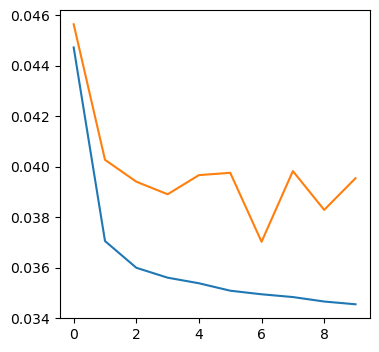

In [17]:
plt.figure(figsize=(4,4))
plt.plot(train_loss_list, label='train')
plt.plot(valid_loss_list, label='valid')
plt.show()